**Homework 6**

In [1]:
#Import libraries and dependencies
import re
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
#Import data into dataframe
df_housing = pd.read_csv("housing.csv")

In [3]:
selected_vars = ["longitude", "latitude", "housing_median_age", "total_rooms", "total_bedrooms", "population", "households", 
               "median_income", "median_house_value", "ocean_proximity"]
dh_housing = df_housing[selected_vars]

In [4]:
#Initial exploration
dh_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
#Fill missing values
df_housing["total_bedrooms"].fillna(0, inplace=True)
df_housing["total_bedrooms"].isna().sum()

0

In [6]:
#Apply log to median_house_value and create target variable
df_housing["log_median_house_value"] = np.log(df_housing["median_house_value"])

In [7]:
#Split dataset in train, validation and test sets

df_housing_full_train, df_housing_test = train_test_split(df_housing, test_size=0.2, random_state=1)
df_housing_train, df_housing_val = train_test_split(df_housing_full_train, test_size=0.25, random_state=1)

df_housing_train = df_housing_train.reset_index(drop=True)
df_housing_val = df_housing_val.reset_index(drop=True)
df_housing_test = df_housing_test.reset_index(drop=True)

y_housing_train = df_housing_train.log_median_house_value.values
y_housing_val = df_housing_val.log_median_house_value.values
y_housing_test = df_housing_test.log_median_house_value.values

df_housing_train.drop(["median_house_value", "log_median_house_value"], axis=1, inplace=True)
df_housing_val.drop(["median_house_value", "log_median_house_value"], axis=1, inplace=True)
df_housing_test.drop(["median_house_value", "log_median_house_value"], axis=1, inplace=True)


In [8]:
#Apply one-hot-encoding using DictVectorizer
dv = DictVectorizer(sparse=False)

train_dict = df_housing_train.to_dict(orient='records')
X_housing_train = dv.fit_transform(train_dict)

**Question 1**

In [10]:
#Train model with decision tree regressor
regressor = DecisionTreeRegressor(max_depth=1)
regressor.fit(X_housing_train, y_housing_train)

DecisionTreeRegressor(max_depth=1)

In [13]:
#Inspect model
from sklearn.tree import export_text
print(export_text(regressor, feature_names=dv.get_feature_names()))

|--- ocean_proximity=INLAND <= 0.50
|   |--- value: [12.31]
|--- ocean_proximity=INLAND >  0.50
|   |--- value: [11.61]



**Question 2**

In [17]:
#Train random forest with specified parameters
n_estimators = 10
random_state = 1
n_jobs = -1
rf = RandomForestRegressor(n_estimators=n_estimators, random_state=random_state, n_jobs=n_jobs)
rf.fit(X_housing_train, y_housing_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [32]:
#define function to calculate RMSE
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [23]:
#Calculate AUC
val_dict = df_housing_val.to_dict(orient='records')
X_housing_val = dv.transform(val_dict)
y_housing_val_pred = rf.predict(X_housing_val)
round(rmse(y_housing_val, y_housing_val_pred),3)

0.245

**Question 3**

In [41]:
#Train random forest with specified parameters
scores = []
random_state = 1
n_jobs = -1

for n in range(10,201,10):
    rf = RandomForestRegressor(n_estimators=n, random_state=random_state, n_jobs=n_jobs)
    rf.fit(X_housing_train, y_housing_train)
    
    val_dict = df_housing_val.to_dict(orient="records")
    X_housing_val = dv.transform(val_dict)
    y_housing_val_pred = rf.predict(X_housing_val)
    rmse = ((y_housing_val_pred - y_housing_val)**2).mean()
    
    scores.append((n, rmse))

columns = ["n_estimators", "rmse"]
df_scores = pd.DataFrame(scores, columns=columns)
df_scores["rmse"] = round(df_scores["rmse"],3)

<AxesSubplot:xlabel='n_estimators'>

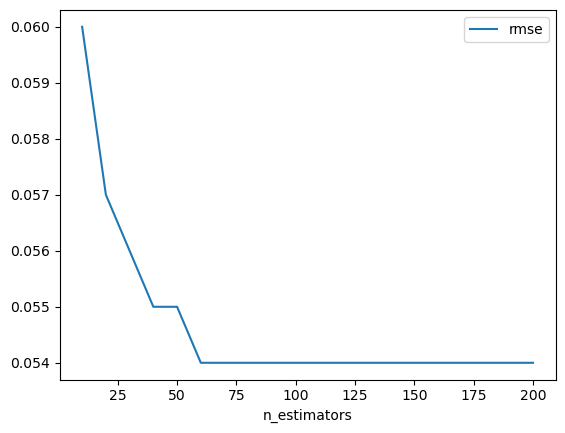

In [42]:
#Plot RMSE values
df_scores.plot(x="n_estimators", y="rmse")

**Question 4**

In [43]:
#Train random forest with specified parameters
scores = []
random_state = 1
n_jobs = -1

for d in [10, 15, 20, 25]:
    for n in range(10,201,10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=d, random_state=random_state, 
                                   n_jobs=n_jobs)
        rf.fit(X_housing_train, y_housing_train)

        val_dict = df_housing_val.to_dict(orient="records")
        X_housing_val = dv.transform(val_dict)
        y_housing_val_pred = rf.predict(X_housing_val)
        rmse = ((y_housing_val_pred - y_housing_val)**2).mean()

        scores.append((d, n, rmse))

columns = ["max_depth", "n_estimators", "rmse"]
df_scores = pd.DataFrame(scores, columns=columns)
df_scores["rmse"] = round(df_scores["rmse"],3)

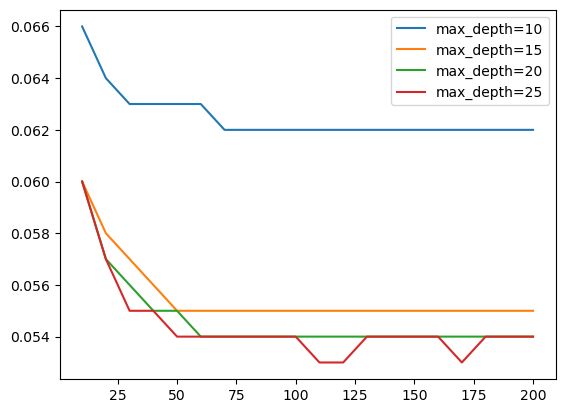

In [46]:
#Plot RMSE values

for d in [10, 15, 20, 25]:
    df_scores_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_scores_subset.n_estimators, df_scores_subset.rmse,
             label='max_depth=%d' % d)

plt.legend()

**Question 5**

/opt/conda/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


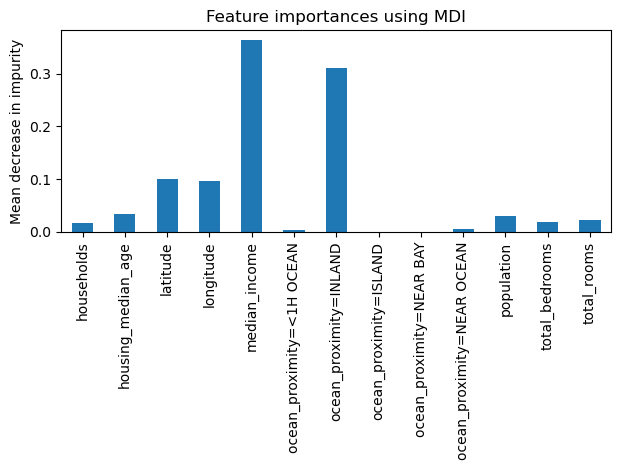

In [57]:
#Train model with specified parameters
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, 
                                   n_jobs=-1)
rf.fit(X_housing_train, y_housing_train)
importances = rf.feature_importances_
feature_names = dv.get_feature_names()

forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar()
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

**Question 6**

In [65]:
import xgboost as xgb

#Create DMatrix for train and validation

features = dv.feature_names_

regex = re.compile(r"<", re.IGNORECASE)
features = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in features]

dtrain = xgb.DMatrix(X_housing_train, label=y_housing_train, feature_names=features)
dval = xgb.DMatrix(X_housing_val, label=y_housing_val, feature_names=features)

In [66]:
#Set watchlist
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [67]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200, evals=watchlist)

[0]	train-rmse:8.12733	val-rmse:8.13244
[1]	train-rmse:5.69586	val-rmse:5.70069
[2]	train-rmse:3.99539	val-rmse:4.00040
[3]	train-rmse:2.80712	val-rmse:2.81078
[4]	train-rmse:1.97834	val-rmse:1.98174
[5]	train-rmse:1.40218	val-rmse:1.40740
[6]	train-rmse:1.00099	val-rmse:1.00699
[7]	train-rmse:0.72751	val-rmse:0.73438
[8]	train-rmse:0.54190	val-rmse:0.55046
[9]	train-rmse:0.42167	val-rmse:0.43233
[10]	train-rmse:0.34481	val-rmse:0.35782
[11]	train-rmse:0.29835	val-rmse:0.31360
[12]	train-rmse:0.27101	val-rmse:0.28869
[13]	train-rmse:0.25275	val-rmse:0.27343
[14]	train-rmse:0.24302	val-rmse:0.26628
[15]	train-rmse:0.23575	val-rmse:0.26099
[16]	train-rmse:0.23035	val-rmse:0.25701
[17]	train-rmse:0.22594	val-rmse:0.25389
[18]	train-rmse:0.22137	val-rmse:0.24960
[19]	train-rmse:0.21743	val-rmse:0.24699
[20]	train-rmse:0.21461	val-rmse:0.24532
[21]	train-rmse:0.21240	val-rmse:0.24460
[22]	train-rmse:0.21152	val-rmse:0.24413
[23]	train-rmse:0.20834	val-rmse:0.24287
[24]	train-rmse:0.20580	va

In [68]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200, evals=watchlist)

[0]	train-rmse:10.44371	val-rmse:10.44937
[1]	train-rmse:9.40118	val-rmse:9.40684
[2]	train-rmse:8.46290	val-rmse:8.46830
[3]	train-rmse:7.61859	val-rmse:7.62390
[4]	train-rmse:6.85878	val-rmse:6.86366
[5]	train-rmse:6.17511	val-rmse:6.17976
[6]	train-rmse:5.55996	val-rmse:5.56444
[7]	train-rmse:5.00644	val-rmse:5.01079
[8]	train-rmse:4.50846	val-rmse:4.51263
[9]	train-rmse:4.06044	val-rmse:4.06456
[10]	train-rmse:3.65747	val-rmse:3.66144
[11]	train-rmse:3.29493	val-rmse:3.29852
[12]	train-rmse:2.96890	val-rmse:2.97268
[13]	train-rmse:2.67580	val-rmse:2.67960
[14]	train-rmse:2.41209	val-rmse:2.41607
[15]	train-rmse:2.17503	val-rmse:2.17860
[16]	train-rmse:1.96209	val-rmse:1.96592
[17]	train-rmse:1.77071	val-rmse:1.77456
[18]	train-rmse:1.59876	val-rmse:1.60289
[19]	train-rmse:1.44451	val-rmse:1.44902
[20]	train-rmse:1.30614	val-rmse:1.31096
[21]	train-rmse:1.18108	val-rmse:1.18618
[22]	train-rmse:1.06956	val-rmse:1.07525
[23]	train-rmse:0.96911	val-rmse:0.97509
[24]	train-rmse:0.87978	